In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras 
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist,cifar10
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from scipy import stats
import warnings
import PrivacyGAN as pg 
from keras.models import load_model
from datetime import datetime
from sklearn.datasets import fetch_lfw_people


warnings.filterwarnings("ignore")
K.set_image_dim_ordering('th')

### Load dataset

In [3]:
lfw_people = fetch_lfw_people()
X_all = lfw_people['data']
X_all = (X_all.astype(np.float32) - 127.5)/127.5

#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print('training set size:',X.shape)
print('test set size:',X_comp.shape)

training set size: (1323, 2914)
test set size: (11910, 2914)


### Simple GAN

In [4]:
generator = pg.LFW_Generator()
discriminator = pg.LFW_Discriminator()
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 500, batchSize = 256,
                                                         discriminator = discriminator,
                                                         generator = generator)

Epochs: 500
Batch size: 256
Batches per epoch: 5.16796875
epoch = 1/500, d_loss=0.609, g_loss=0.679                                                                                                                  
epoch = 2/500, d_loss=0.542, g_loss=0.728                                                                                                                  
epoch = 3/500, d_loss=0.513, g_loss=0.796                                                                                                                  
epoch = 4/500, d_loss=0.509, g_loss=0.807                                                                                                                  
epoch = 5/500, d_loss=0.514, g_loss=0.804                                                                                                                  
epoch = 6/500, d_loss=0.503, g_loss=0.818                                                                                                                  
epoch 

In [6]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.8435374149659864


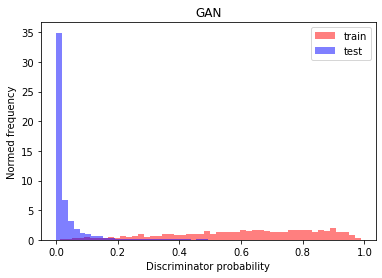

In [7]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

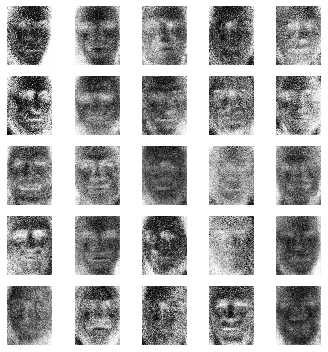

In [8]:
#generate synthetic images
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generator.predict(noise)
temp = generatedImages[:25].reshape(25, 62, 47)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

### Private GAN

In [9]:
K.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generators = [pg.LFW_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              pg.LFW_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [pg.LFW_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                  ,pg.LFW_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = pg.LFW_DiscriminatorPrivate(OutSize = 2, 
                                      optim = Adam(lr=0.0002, beta_1=0.5))

(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 500, 
                                                                           disc_epochs=50,
                                                                           batchSize=256,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio = 1.0)

Train on 1323 samples, validate on 1323 samples
Epoch 1/50
1323/1323 [==============================] - 1s 850us/step - loss: 0.7394 - val_loss: 0.6864
Epoch 2/50
1323/1323 [==============================] - 0s 33us/step - loss: 0.6552 - val_loss: 0.6064
Epoch 3/50
1323/1323 [==============================] - 0s 33us/step - loss: 0.6127 - val_loss: 0.6307
Epoch 4/50
1323/1323 [==============================] - 0s 32us/step - loss: 0.6126 - val_loss: 0.5878
Epoch 5/50
1323/1323 [==============================] - 0s 32us/step - loss: 0.5636 - val_loss: 0.5114
Epoch 6/50
1323/1323 [==============================] - 0s 32us/step - loss: 0.5340 - val_loss: 0.8636
Epoch 7/50
1323/1323 [==============================] - 0s 32us/step - loss: 0.6366 - val_loss: 0.5378
Epoch 8/50
1323/1323 [==============================] - 0s 32us/step - loss: 0.4894 - val_loss: 0.4565
Epoch 9/50
1323/1323 [==============================] - 0s 33us/step - loss: 0.4485 - val_loss: 0.6105
Epoch 10/50
1323/1323 [=

In [10]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.09070294784580499
White-box attack accuracy (mean): 0.09145880574452003


(0.09070294784580499, 0.09145880574452003)

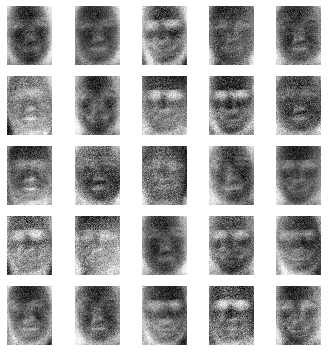

In [11]:
#generate synthetic images
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generators[0].predict(noise)
temp = generatedImages[:25].reshape(25, 62, 47)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

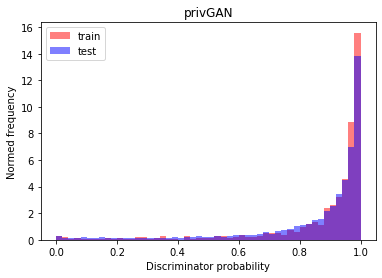

In [12]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()